In [1]:
import healpy as hp
from orphics import sehgal as osehgal, maps as omaps
from cosmikyu import sehgal, config as cconfig
from pixell import enmap, enplot, utils, colorize, reproject
import os
import numpy as np
import matplotlib.pyplot as plt
import time 
import gc

from PIL import Image
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/catalogues"
shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ydel = shape[0] // 9
print(shape, ydel)
template = enmap.zeros(shape, wcs)[ydel*4:(ydel)*5,:]
nshape, nwcs = template.geometry
taper = omaps.get_taper(nshape, nwcs, pad_percent=0)[0]


S10R = sehgal.Sehgal10Reprojected(input_dir, nshape, nwcs)
compts = ["kappa",  "ksz",  "tsz", "ir", "rad"]

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)


output_dir = "/home/dwhan89/workspace/cosmikyu/output"
def output_path(x):
    return os.path.join(output_dir, x)


(21601, 43200) 2400


In [3]:
cuda = True
ngpu = 4
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/clkk_sim.npy"
cmb_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat"

xgrid_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/0.5_fullsky_gridv2_21600x43200.npy"
weight_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/0.5_fullsky_weightv3_21600x43200.npy"

experiment_id = "6dd3053687de464aabc4a2bb441e60cf"
save_point = 6
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/{}/model".format(experiment_id)
pixgan_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

experiment_id = "6c187e10f7ad45c8b6e6ebb7c0b15d31"
save_point = 13
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_281220/{}/model".format(experiment_id)
tuner_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

#transfer_file = os.path.join(input_dir,"281220_sehgal_network_transfer.npy")
transfer_2dspec_file = '/home/dwhan89/workspace/cosmikyu/output/mlsimsv0.11_transf_2dspec_final.npz'
transfer_1dspec_file = '/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/mlsimsv0.1_transf_1dspec.npz'

output_dir = cconfig.default_output_dir

cache_dir = os.path.join(output_dir, "cache")
sim_dir = os.path.join(output_dir, "sim")

os.makedirs(sim_dir, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)


SN = sehgal.SehgalNetworkFullSky(cuda, ngpu, 512, norm_info_file, 
                          pixgan_state_file, tuner_state_file, spec_file, transfer_1dspec_file, transfer_2dspec_file, 20, 80, xgrid_file, 
                                 weight_file, cache_dir=cache_dir,)


TypeError: __init__() got an unexpected keyword argument 'cache_dir'

In [ ]:
NSIDE = 8192
hparea =  hp.pixelfunc.nside2pixarea(NSIDE)

sehgal_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/inputs/microwaveSky"
SEHGAL10 = osehgal.SehgalSky2010(path=sehgal_dir, data_type='healpix')
rfs = {"kappa": lambda : SEHGAL10.get_kappa(),
       "ksz": lambda : SEHGAL10.get_ksz(148),
       "tsz": lambda :SEHGAL10.get_tsz(148),
       "rad_pts": lambda :SEHGAL10.get_radio(148),
       "ir_pts": lambda :SEHGAL10.get_cib(148)
      }

flux_cut = 7e-3
hpmaps = {}
for compt_idx in rfs:
    compt_idx_trimmed = compt_idx.split("_")[0]
    hpmaps[compt_idx_trimmed] = rfs[compt_idx]()
    if compt_idx_trimmed in ["rad", "ir"]:
        hpmap = hpmaps[compt_idx_trimmed]
        loc = np.where(np.abs(hpmap) >= flux_cut/hparea*sehgal.jysr2thermo(148))
        hpmap[loc] = 0
        hpmaps[compt_idx_trimmed] = hpmap
        print("flux cut", compt_idx_trimmed, len(loc[0]))

In [ ]:

overwrite = False
for sim_idx in range(1):
    gc.collect()
    output_file = output_path(f"mlsimsv0.12_{sim_idx:05}_processed_hp.fits")
    if not os.path.exists(output_file) or overwrite:
        print(output_file)
        mlsims = enmap.read_map(output_path(f"mlsimsv0.12_{sim_idx:05}_processed.fits"), wcs=SN.wcs)
        npix = hp.pixelfunc.nside2npix(8192)
        hpmaps = np.zeros((5,npix), dtype=np.float32)
        
        stime = time.time()
        for i in range(5):
            if i < 3:
                hpmaps[i] = reproject.healpix_from_enmap(mlsims[i],10000,8192)
            else:
                hpmaps[i] = enmap.to_healpix(mlsims[i], omap=None, nside=8192, order=3, chunk=100000, destroy_input=False)
            print(i, time.time()-stime)
        hp.write_map(output_file, hpmaps.astype(np.float32), overwrite=True)
        del mlsims, hpmaps
        
gc.collect()

NSIDE = 8192
hparea =  hp.pixelfunc.nside2pixarea(NSIDE)
compts = ["kappa", "ksz", "tsz", "ir", "rad"]

sim_idx = 0
temp = hp.read_map(output_path(f"mlsimsv0.12_{sim_idx:05}_processed_hp.fits"), field=(0,1,2,3,4))
mlmaps = {}

for i, compt_idx in enumerate(compts):
    compt_idx_trimmed = compt_idx.split("_")[0]
    mlmaps[compt_idx_trimmed] = temp[i].copy()
del temp

In [4]:
def key2label(key):
    storage = {"kappa":"Kappa",
               "ksz":"kSZ ",
               "tsz":"tSZ ",
               "ir":"CIB ",
               "rad":"Radio",
              }
    return storage[key]

def key2minmax(key):
    storage = {"kappa":(-0.5,0.5),
           "ksz":(-10,10),
           "tsz":(-50,50),
           "ir":(-50,50),
           "rad":(-20,20),
          }
    return storage[key]

In [5]:
def set_background(im, tpad=0, bpad=0, lpad=0, rpad=0, color = "#FFFFFF" ):
    dst = Image.new('RGB', (im.width+lpad+rpad, im.height+tpad+bpad), color=color)
    dst.paste(im, (lpad,tpad))
    return dst

def get_concat_h(im1, im2, wspace=0):
    dst = Image.new('RGB', (im1.width+wspace + im2.width, im1.height), color="#FFFFFF")
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width+wspace, 0))
    return dst

def get_concat_v(im1, im2, hspace=40):
    dst = Image.new('RGB', (im1.width, im1.height+hspace+im2.height), color="#FFFFFF")
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height+hspace))
    return dst

def pad(im, tpad=30, bpad=0, lpad=0, rpad=0):
    dst = Image.new('RGB', (im.width+(lpad+rpad), im.height+(tpad+bpad)), color="#FFFFFF")
    dst.paste(im, (lpad, tpad))
    return dst

    

In [6]:


width = 601
height = 355

for compt_idx in compts[:]:
    unit = "" if compt_idx == "kappa" else r" $[\mu K]$"
    minval, maxval = key2minmax(compt_idx)
    hp.mollview(hpmaps[compt_idx], cmap=colorize.to_mpl_colormap("planck"),
                min=minval, max=maxval, xsize=1600, title="")
    plt.gca().images[0].colorbar.ax.tick_params(labelsize=18)
    plt.savefig(plot_path(f"s{compt_idx}_mollview.png"), bbox_inches='tight')
    
for compt_idx in compts[:]:
    unit = "" if compt_idx == "kappa" else r" $[\mu K]$"
    minval, maxval = key2minmax(compt_idx)
    hp.mollview(mlmaps[compt_idx], cmap=colorize.to_mpl_colormap("planck"),
                min=minval, max=maxval, xsize=1600, title=""
               )
    plt.gca().images[0].colorbar.ax.tick_params(labelsize=18)
    plt.savefig(plot_path(f"ng{compt_idx}_mollview.png"), bbox_inches='tight')




NameError: name 'hpmaps' is not defined

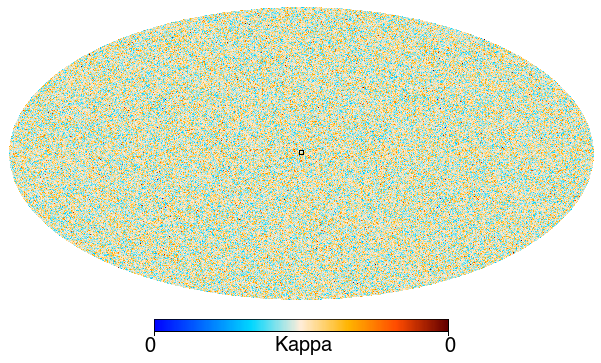

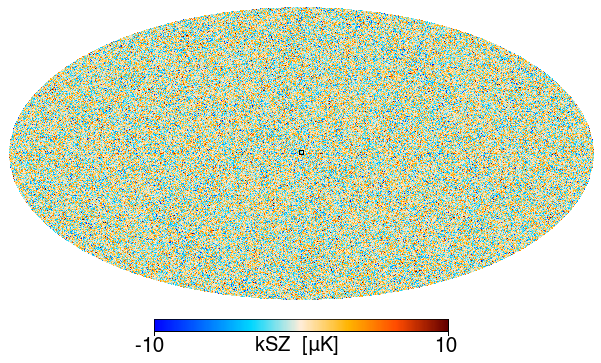

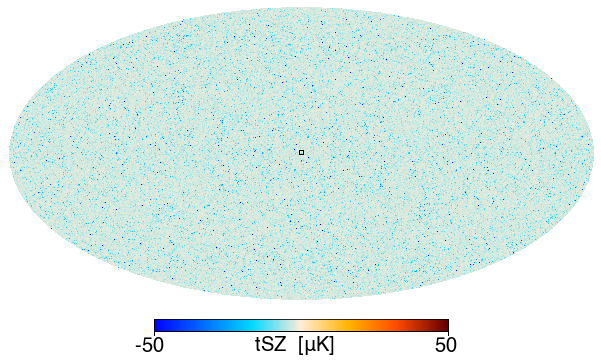

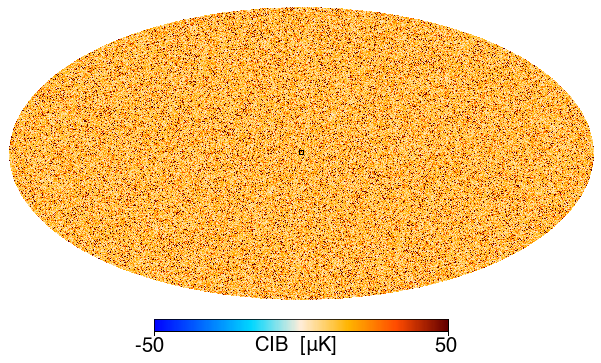

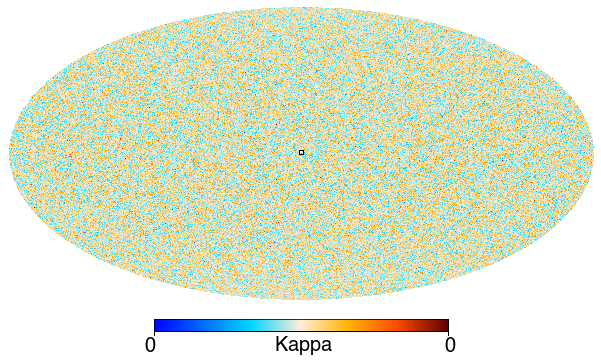

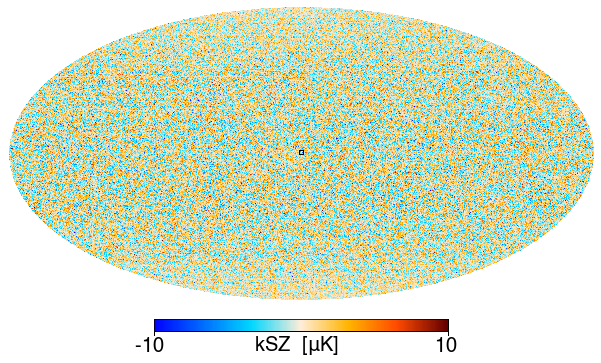

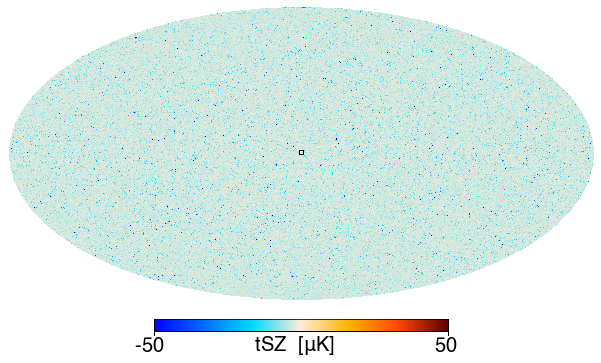

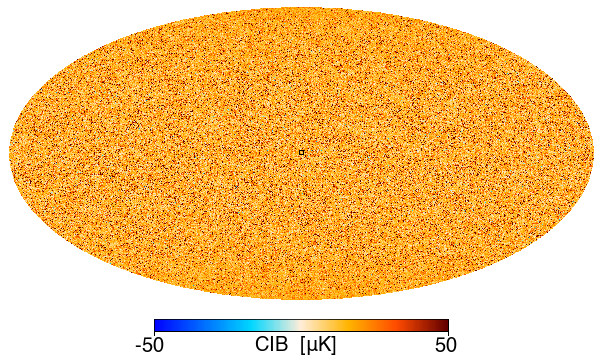

In [7]:
show_plot = True
simgs_molloview = [None]*4
ngimgs_molloview = [None]*4

for i, compt_idx in enumerate(compts[:4]):
    temp = Image.open(plot_path(f"s{compt_idx}_mollview.png"))
    temp = set_background(temp)
    draw = ImageDraw.Draw(temp)

    font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica.ttf", 20)
    unit = " [μK]" if compt_idx != "kappa" else ""
    label = key2label(compt_idx) + unit
    

    #font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica-Bold.ttf", 17)
    #draw.text((130, 320), text="μK", fill="black",font=font)
    #draw.text((453, 320), text="μK", fill="black",font=font)
    draw.rectangle([301-2,152-2,301+2,152+2], outline="black")
    draw.rectangle([150-20,345-8,150+20,345+8], fill="white")
    draw.rectangle([450-20,345-8,450+20,345+8], fill="white")
    
    minval, maxval = key2minmax(compt_idx)
    minval = str(int(minval))
    maxval = str(int(maxval))
    draw.text((150-len(minval)*5, 336), text=minval, fill="black",font=font)
    draw.text((450-len(minval)*5, 336), text=maxval, fill="black",font=font)
    draw.text((300-len(label)*5, 335), text=label, fill="black",font=font)
    simgs_molloview[i] = temp.copy()
    #temp.save(file_name, "png")
    #plt.savefig(Image.open(plot_path(f"s{compt_idx}_mollview.png")))
    if show_plot:
        display(temp)
        plt.show()
        
for i, compt_idx in enumerate(compts[:4]):
    temp = Image.open(plot_path(f"ng{compt_idx}_mollview.png"))
    temp = set_background(temp)
    draw = ImageDraw.Draw(temp)

    draw.rectangle([301-2,152-2,301+2,152+2], outline="black")
    draw.rectangle([150-20,345-8,150+20,345+8], fill="white")
    draw.rectangle([450-20,345-8,450+20,345+8], fill="white")
    

    
    
    font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica.ttf", 20)
    #label = key2label(compt_idx)
    unit = " [μK]" if compt_idx != "kappa" else ""
    label = key2label(compt_idx) + unit
    minval, maxval = key2minmax(compt_idx)
    minval = str(int(minval))
    maxval = str(int(maxval))
    draw.text((150-len(minval)*5, 336), text=minval, fill="black",font=font)
    draw.text((450-len(minval)*5, 336), text=maxval, fill="black",font=font)
    draw.text((300-len(label)*5, 335), text=label, fill="black",font=font)
    ngimgs_molloview[i] = temp
    #temp.save(file_name, "png")
    if show_plot:
        display(temp)
        plt.show()


In [ ]:
show_plot = False
simg_molloview = simgs_molloview[0].copy()
ngimg_molloview = ngimgs_molloview[0].copy()
for i in range(1,4):
    simg_molloview = get_concat_v(simg_molloview, simgs_molloview[i], 0)
    ngimg_molloview = get_concat_v(ngimg_molloview, ngimgs_molloview[i], 0)
    
if show_plot:
    display(simg_molloview)
    plt.show()
    display(ngimg_molloview)
    plt.show()


In [ ]:
merged_mollview = get_concat_h(simg_molloview, ngimg_molloview)
merged_mollview = pad(merged_mollview, tpad=50)
draw = ImageDraw.Draw(merged_mollview)
font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica-Bold.ttf", 30)
draw.text((275, 15), text="S10", fill="black",font=font)
draw.text((840, 15), text="Network", fill="black",font=font)

display(merged_mollview)
file_name = plot_path(f"merged_mollview.png")
merged_mollview.save(file_name, "png")
plt.show()


In [ ]:
#sshape, swcs = omaps.rect_geometry(width_deg=1, px_res_arcmin=0.5)
#stamp = enmap.zeros(sshape, swcs)
S10R = sehgal.Sehgal10ReprojectedFromCat(input_dir, nshape, nwcs)
smapr = S10R.get_maps(60,40, load_processed=False, ret_alm=False, flux_cut=7)
smapr = smapr[[0,1,2,3,4],1200-60:1200+60, 21600-60:21600+60]

'''
loc = np.where(hpmaps["rad"]>0)[0]
ctr = 0
storage = np.zeros((len(loc), 3))
ra, dec = hp.pixelfunc.pix2ang(NSIDE, loc, lonlat=True)
storage[:,1] = ra.copy()
storage[:,0] = dec.copy()
storage[:,2] = hpmaps["rad"][loc].copy()
del ra, dec

loc = np.where(175<=storage[:,1])[0]
storage = storage[loc,...]
loc = np.where(storage[:,1]<=185)[0]
storage = storage[loc,...]
loc = np.where(-5<=storage[:,0])[0] 
storage = storage[loc,...]
loc = np.where(storage[:,0]<=5)[0]
storage = storage[loc,...]

storage[:,0] = storage[:,0]*utils.degree
storage[:,1] = storage[:,1]*utils.degree-np.pi
storage[:,2] *= hparea/(0.5*utils.arcmin)**2
pixes  = enmap.sky2pix(sshape, swcs, storage[:,:2].T).astype(np.int).T
smapr[4,...]  = 0.
smapr[4,pixes[:,0], pixes[:,1]] = storage[:,2].copy()
'''
pass

In [ ]:
#ngmap = SN.generate_samples(seed=4, edge_blend=True, wrap_mode=("reflect","wrap"), 
#                                 use_sht=False, transfer=True, deconv_beam=False, ret_corr=False, post_processes=[],
#                              use_cache=True, flux_cut=7)

ngmap = enmap.read_map(output_path(f"mlsimsv0.12_{sim_idx:05}_processed.fits"), wcs=SN.wcs)
ngmap = enmap.extract(ngmap, nshape,nwcs)


In [ ]:
temp = 1300
ngsmap = ngmap[[0,1,2,3,4],temp:temp+120,temp+230:temp+120+230].copy()

In [ ]:
for i, compt_idx in enumerate(compts):
    minval, maxval = key2minmax(compt_idx)
    print(compt_idx, minval, maxval)
    enplot.pshow(smapr[i],grid=False, downgrade=1, color="planck", min=minval, max=maxval)
    img = enplot.plot(smapr[i],grid=False, downgrade=1, color="planck", min=minval, max=maxval)
    file_name = plot_path(f"s{compt_idx}_stamp")
    enplot.write(file_name, img)
    enplot.pshow(ngsmap[i],grid=False, downgrade=1, color="planck", min=minval, max=maxval)
    img = enplot.plot(ngsmap[i],grid=False, downgrade=1, color="planck", min=minval, max=maxval)
    file_name = plot_path(f"ng{compt_idx}_stamp")
    enplot.write(file_name, img)

In [ ]:

def paste(im1, im2, x, y):
    im1.paste(im2, (x, y))
    return im1

file_name = plot_path(f"merged_mollview.png")
final = Image.open(file_name)

for i, compt_idx in enumerate(compts[:4]):
    x = 470
    y = 140+i*365
    file_name = plot_path(f"s{compt_idx}_stamp.png")
    sstamp = set_background(Image.open(file_name),2,2,2,2,"#000000")
    final = paste(final, sstamp, x, y)
    draw = ImageDraw.Draw(final)
    draw.line([(298,y+60-2*i),(x,y)], fill="black", width=1)
    draw.line([(298,y+63-2*i),(x,y+122)], fill="black", width=1)
    
    x += 132
    file_name = plot_path(f"ng{compt_idx}_stamp.png")
    sstamp = set_background(Image.open(file_name),2,2,2,2,"#000000")
    final = paste(final, sstamp, x, y)
    draw = ImageDraw.Draw(final)
    draw.line([(x+303,y+60-2*i),(x+120,y)], fill="black", width=1)
    draw.line([(x+303,y+63-2*i),(x+120,y+123)], fill="black", width=1)
    
display(final)
file_name = plot_path("030921_full_stacked")
final.save(file_name, "png")
plt.show()